# Import Libraries

In [ ]:
from google.colab import files
import json
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, \
Dense, Dropout, Input, add
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, \
 recall_score, confusion_matrix, precision_recall_curve
from tensorflow.keras.models import save_model, load_model
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import os
import random
import time

# Download data dari Kaggle

In [ ]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

token = {"username":"kskaran94","key":"e845a1f4ce47bb7f34dc6ec9f108f676"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

! chmod 600 /root/.kaggle/kaggle.json

! kaggle datasets download -d techsash/waste-classification-data

cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/techsash/waste-classification-data
License(s): CC-BY-SA-4.0


#Unzip data

In [ ]:
!unzip waste-classification-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/DATASET/TRAIN/R/R_5499.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_55.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_550.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5500.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5501.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5502.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5503.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5504.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5505.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5506.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5507.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5508.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5509.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_551.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5510.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5511.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5512.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5513.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5514.jpg  
  i

# Struktur file dataset

In [ ]:
!ls DATASET/

TEST  TRAIN


In [ ]:
!ls DATASET/TRAIN/

O  R


In [ ]:
dataset_path = "DATASET/TRAIN"
categories = os.listdir(dataset_path)

for category in categories:
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        num_files = len(os.listdir(category_path))
        print(f"Kategori '{category}': {num_files} gambar")

Kategori 'O': 12565 gambar
Kategori 'R': 9999 gambar


In [ ]:
dataset_path = "DATASET/TEST"
categories = os.listdir(dataset_path)

for category in categories:
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        num_files = len(os.listdir(category_path))
        print(f"Kategori '{category}': {num_files} gambar")

Kategori 'O': 1401 gambar
Kategori 'R': 1112 gambar


# Copying files

In [ ]:
def copyfiles(file_names, dest, src_path):
    for file in file_names:
        full_file_name = os.path.join(src_path, file)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, dest)

# Train Validation Split

In [ ]:
def train_val_test_split(path, perc):
    train_string = 'train/'
    val_string = 'val/'
    dest_path = '/content/'

    try:
        os.mkdir(dest_path + train_string)
        os.mkdir(dest_path + val_string)
    except:
        shutil.rmtree(dest_path + train_string)
        shutil.rmtree(dest_path + val_string)
        os.mkdir(dest_path + train_string)
        os.mkdir(dest_path + val_string)

    sub_direc = os.listdir(path=path)

    for sub in sub_direc:
        if sub in ['O', 'R']:
            try:
                shutil.rmtree(dest_path + train_string + sub)
                shutil.rmtree(dest_path + val_string + sub)
            except:
                os.makedirs(dest_path + train_string + sub)
                os.makedirs(dest_path + val_string + sub)

            src_path = path + sub
            filenames = os.listdir(src_path)
            filenames.sort()
            # Pastikan urutan nama file tetap sebelum dilakukan pengacakan

            random.shuffle(filenames)
            # Mengacak urutan nama file (hasilnya akan tetap sama jika seed ditentukan)

            split_1 = int(perc * len(filenames))
            train_filenames = filenames[:split_1]
            val_filenames = filenames[split_1:]

            copyfiles(train_filenames, dest_path + train_string + sub, src_path)
            # Menyalin file untuk set pelatihan (train) pada setiap kelas

            copyfiles(val_filenames, dest_path + val_string + sub, src_path)
            # Menyalin file untuk set validasi (val) pada setiap kelas

In [ ]:
train_val_test_split('DATASET/TRAIN/', 0.8)

# Predict from generator

In [ ]:
def predict_from_generator(generator, model):
    pred = model.predict_generator(generator)
    predicted_class_indices = np.argmax(pred, axis = -1)
    classes = generator.classes[generator.index_array]
    return predicted_class_indices, classes

# Data Preparation and Config

In [ ]:
batch_size=64

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
            'train/',  # this is the target directory
            target_size=(150, 150),  # all images will be resized to 150x150
            batch_size=batch_size,
            class_mode='categorical',shuffle=True)

val_generator = val_datagen.flow_from_directory(
        'val/',  # this is the target directory
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical',shuffle=False)


test_generator = test_datagen.flow_from_directory(
        'DATASET/TEST/',  # this is the target directory
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical',shuffle=False)

Found 18051 images belonging to 2 classes.
Found 4513 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


# Model Definition

In [ ]:
num_classes = 2
input_shape = (150, 150, 3)

cnn_small_bn = Sequential([
    Conv2D(8, kernel_size = (3,3), input_shape=input_shape, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(8, kernel_size = (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(num_classes, activation='softmax'),
                 ])

cnn_small_bn.summary()

cnn_small_bn.compile("adam", "categorical_crossentropy",
                     metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │          20,738 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,546 (84.16 KB)

 Trainable params: 21,546 (84.16 KB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [ ]:
train_size = train_generator.samples
val_size = val_generator.samples


history_cnn = cnn_small_bn.fit(
    train_generator,
    steps_per_epoch=int(train_size // batch_size),
    epochs=10,
    validation_data=val_generator,
    validation_steps=int(val_size // batch_size)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
119/282 ━━━━━━━━━━━━━━━━━━━━ 1:47 657ms/step - accuracy: 0.7527 - loss: 0.5153

KeyboardInterrupt: 

<Axes: >

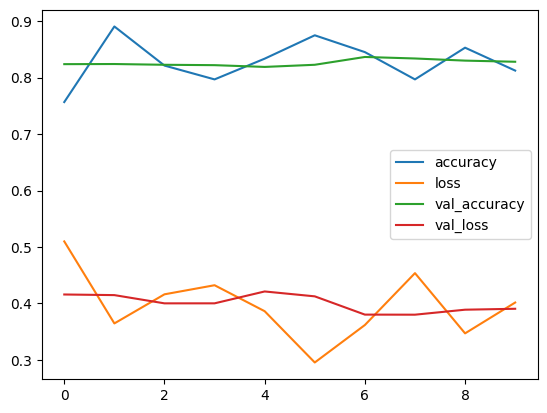

In [ ]:
pd.DataFrame(history_cnn.history).plot()

71/71 ━━━━━━━━━━━━━━━━━━━━ 22s 304ms/step
The recall is  0.8485
The precision is 0.783471837488458


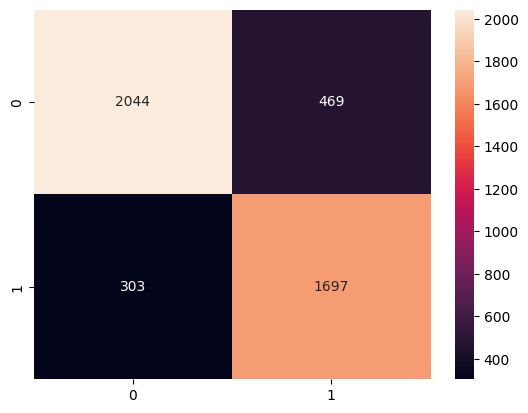

In [ ]:
val_pred = cnn_small_bn.predict(val_generator)
val_classes = val_generator.classes
val_pred = np.argmax(val_pred, axis=-1)


cnf_matrix_val = confusion_matrix(val_classes, val_pred)

fig1 = sns.heatmap(cnf_matrix_val, annot=True, fmt="d")


print("The recall is ", recall_score(val_classes, val_pred))

print("The precision is", precision_score(val_classes, val_pred))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 299ms/step
The recall is  0.7131294964028777
The precision is 0.9329411764705883


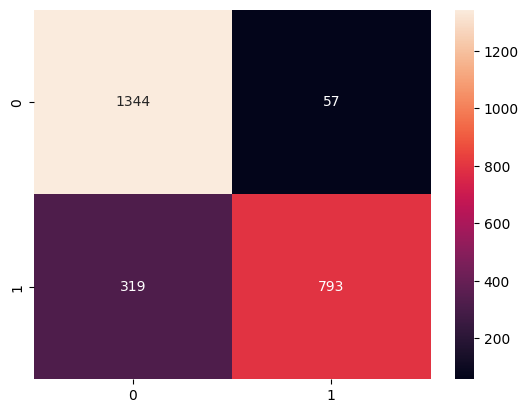

In [ ]:
def predict_from_generator(generator, model):
    pred = model.predict(generator)
    predicted_class_indices = np.argmax(pred, axis=-1)
    classes = generator.classes[generator.index_array]
    return predicted_class_indices, classes

# Then call the function
test_pred, test_classes = predict_from_generator(test_generator, cnn_small_bn)

# Calculate confusion matrix and metrics
cnf_matrix_test = confusion_matrix(test_classes, test_pred)
fig1 = sns.heatmap(cnf_matrix_test, annot=True, fmt="d")

print("The recall is ", recall_score(test_classes, test_pred))
print("The precision is", precision_score(test_classes, test_pred))

# Improving Model

In [ ]:
num_classes = 2
input_shape = (150, 150, 3)


cnn_small_bn_v3 = Sequential([

    Conv2D(16, kernel_size = (4,4), input_shape=input_shape, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size = (4,4), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size = (4,4), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size = (4,4), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(16),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
                 ])

cnn_small_bn_v3.summary()

cnn_small_bn_v3.compile("adam", "categorical_crossentropy",
                     metrics=['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 147, 147, 16)        │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 73, 73, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 70, 70, 16)          │           4,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 35, 35, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 16)          │           4,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 13, 13, 16)          │           4,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           9,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,386 (87.45 KB)

 Trainable params: 22,386 (87.45 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_cnn = cnn_small_bn_v3.fit(
    train_generator,
    steps_per_epoch=int(train_size/batch_size),
    epochs=20,
    verbose=1,
    validation_data=val_generator,
    validation_steps=int(val_size/batch_size))

Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - accuracy: 0.7555 - loss: 0.5255 - val_accuracy: 0.8292 - val_loss: 0.3946
Epoch 2/20
  1/282 ━━━━━━━━━━━━━━━━━━━━ 5:09 1s/step - accuracy: 0.8906 - loss: 0.3162

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


282/282 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - accuracy: 0.8906 - loss: 0.3162 - val_accuracy: 0.8286 - val_loss: 0.3937
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 444s 2s/step - accuracy: 0.8207 - loss: 0.4254 - val_accuracy: 0.8513 - val_loss: 0.3708
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - accuracy: 0.7656 - loss: 0.4622 - val_accuracy: 0.8438 - val_loss: 0.3755
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.8349 - loss: 0.3957 - val_accuracy: 0.8580 - val_loss: 0.3370
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 41s 140ms/step - accuracy: 0.8750 - loss: 0.3532 - val_accuracy: 0.8578 - val_loss: 0.3471
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 423s 1s/step - accuracy: 0.8461 - loss: 0.3747 - val_accuracy: 0.8667 - val_loss: 0.3213
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 50s 174ms/step - accuracy: 0.7969 - loss: 0.4043 - val_accuracy: 0.8667 - val_loss: 0.3213
Epoch 9/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 0.8523 - loss: 0.3583 - val_accurac

<Axes: >

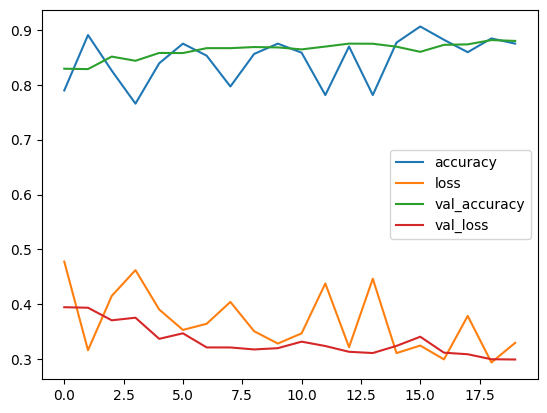

In [ ]:
pd.DataFrame(history_cnn.history).plot()

71/71 ━━━━━━━━━━━━━━━━━━━━ 30s 422ms/step
The recall is  0.8575
The precision is 0.8696754563894523


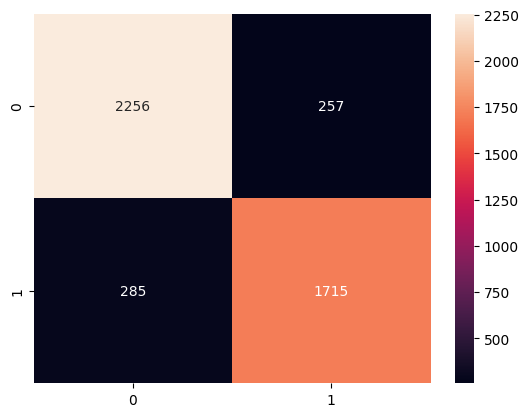

In [ ]:
val_pred, val_classes = predict_from_generator(val_generator, cnn_small_bn_v3)


cnf_matrix_val = confusion_matrix(val_classes, val_pred)

fig1 = sns.heatmap(cnf_matrix_val, annot=True, fmt="d")

print("The recall is ", recall_score(val_classes, val_pred))

print("The precision is", precision_score(val_classes, val_pred))

40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 372ms/step
The recall is  0.8237410071942446
The precision is 0.9224572004028198


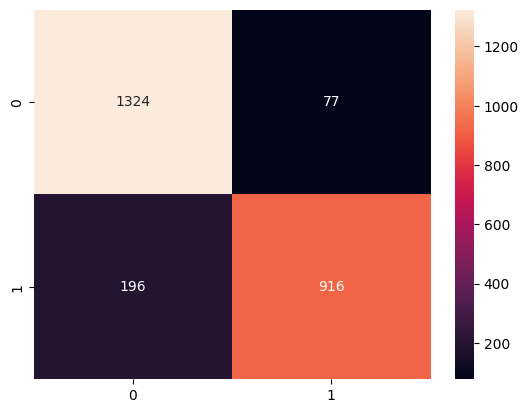

In [ ]:
test_pred, test_classes = predict_from_generator(test_generator, cnn_small_bn_v3)


cnf_matrix_test = confusion_matrix(test_classes, test_pred)

fig1 = sns.heatmap(cnf_matrix_test, annot=True, fmt="d")


print("The recall is ", recall_score(test_classes, test_pred))

print("The precision is", precision_score(test_classes, test_pred))

# Menyimpan Model

In [ ]:
cnn_small_bn_v3.save("sortify_ai.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

cnn_small_bn_v3.save("/content/drive/My Drive/sortify_ai.h5")

Mounted at /content/drive


In [ ]:
cnn_small_bn_v3.save("sortify_ai.keras")

In [ ]:
cnn_small_bn_v3.save("/content/drive/My Drive/sortify_ai.keras")

In [31]:
print(os.path.exists("sortify_ai.keras"))  # Untuk file lokal
print(os.path.exists("/content/drive/My Drive/sortify_ai.keras"))  # Untuk Google Drive

True
True
